In [1]:
import requests
res = requests.get('http://foodmap.isti.cnr.it:9200', auth=('elastic', 'changeme'))
print(res.content)

{
  "name" : "0PsTttc",
  "cluster_name" : "foodmap-cluster",
  "cluster_uuid" : "2YIbFkvuRqaPWhEjuEYnwA",
  "version" : {
    "number" : "5.4.0",
    "build_hash" : "780f8c4",
    "build_date" : "2017-04-28T17:43:27.229Z",
    "build_snapshot" : false,
    "lucene_version" : "6.5.0"
  },
  "tagline" : "You Know, for Search"
}



### ES Auth

In [2]:
from elasticsearch import Elasticsearch
es = Elasticsearch(['foodmap.isti.cnr.it'], http_auth=('elastic', 'changeme'), port=9200)
print es

<Elasticsearch([{u'host': u'foodmap.isti.cnr.it'}])>


In [22]:
result = es.search(index='agg', doc_type='count', size=1000000, body={
    'query': {
        "match_all" : {}
    }
})

lst = [x for x in result['hits']['hits']]
print len(lst)
for l in lst[:10]:
    print l

28203
{u'_score': 1.0, u'_type': u'count', u'_id': u'1115', u'_source': {u'category': u'breakfast burrito', u'date': 20170315, u'count': 35, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1123', u'_source': {u'category': u'breakfast burrito', u'date': 20170313, u'count': 26, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1124', u'_source': {u'category': u'breakfast burrito', u'date': 20170324, u'count': 25, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1128', u'_source': {u'category': u'breakfast burrito', u'date': 20170320, u'count': 22, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1131', u'_source': {u'category': u'breakfast burrito', u'date': 20170317, u'count': 20, u'country': u'united states'}, u'_index': u'agg'}
{u'_score': 1.0, u'_type': u'count', u'_id': u'1136', u'_source': {u'

## Query by

In [99]:
from itertools import groupby
from collections import defaultdict
# the interval is currently implicit
dateBegin = 0
dateEnd = 20180400
category = 'sushi'
# country = 'united states'
country = 'italy'

In [92]:
# Query by food category - Fig. 2b,c Map/Report of Trends/Popularity
def query_by_category(category):
    result = es.search(index='agg', doc_type='count', size=100000, body={
        "query": {        
            "bool" : {                
                "filter": [
                    {"term" : { "category.keyword" : category }},
                    {"range": {            
                        "date" : {            
                            "gte" : dateBegin,
                            "lte" : dateEnd
                        }            
                    }}
                ]            
            }
        }
    })
    return result

In [93]:
# Query by food category - Fig. 2a Report of Trends/Popularity
def query_by_country(country):
    result = es.search(index='agg', doc_type='count', size=100000, body={
        "query": {        
            "bool" : {                
                "filter": [
                    {"term" : { "country.keyword" : country }},
                    {"range": {            
                        "date" : {            
                            "gte" : dateBegin,
                            "lte" : dateEnd
                        }            
                    }}
                ]            
            }
        }
    })
    return result

## Trends / Popularity based on query_by_category

In [124]:
# get trends 
result = query_by_category(category)

def get_trend_per_country(query_result, analysis_type="trend"):
    country_dict = defaultdict(list)
    for x in query_result['hits']['hits']:
        country_dict[x["_source"]['country']].append(tuple((x["_source"]['date'],x["_source"]['count'])))
    
    country_trend = defaultdict(float)
    for country, values in country_dict.iteritems():
        # sort list by date ascending
        sorted_counts = sorted(values, key=lambda x: x[0])
        # we refer to the current day in the interval
        if analysis_type == "frequency":
            country_trend[country] = sum([y for x,y in sorted_counts])
        elif analysis_type == "popularity":
            country_trend[country] = stats.zscore([y for x,y in sorted_counts])[-1] 
        elif analysis_type == "trend":
            y = [y for x,y in sorted_counts]
            x = np.arange(len(y))
            try:
                regression = np.polyfit(x, y, 1)
                country_trend[country] = regression[0]
            except:
                # the fir doesn't work for this example: np.polyfit(np.array([0]), np.array([1]), 1)
                # some versions of numpy return nan, as should we
                country_trend[country] = np.nan
            
    return country_trend

newd = get_trend_per_country(result, analysis_type="frequency")
# newd = get_category_trend_per_country(result, analysis_type="popularity")
print [(x,y) for x,y in newd.iteritems()]

# WHY zscore is NaN - division by 0
# sorted_counts_lit = sorted(country_dict['lithuania'], key=lambda x: x[0])
# print stats.zscore([y for x,y in sorted_counts_lit])
# print sorted_counts_lit

[(u'east timor', 1), (u'korea, republic of', 31), (u'azerbaijan', 3), (u'uzbekistan', 2), (u'senegal', 2), (u'cambodia', 32), (u'japan', 1128), (u'taiwan', 64), (u'cyprus', 29), (u'barbados', 16), (u'the former yugoslav republic of macedonia', 1), (u'bhutan', 1), (u'switzerland', 121), (u'lithuania', 12), (u'mongolia', 2), (u'united kingdom', 13979), (u'tunisia', 24), (u'british virgin islands', 5), (u'puerto rico', 229), (u'argentina', 776), (u'norway', 84), (u'sierra leone', 1), (u'ghana', 43), (u'belarus', 14), (u'cuba', 12), (u'zambia', 3), (u'guatemala', 49), (u'zimbabwe', 21), (u'poland', 212), (u'belgium', 255), (u'haiti', 12), (u'kazakhstan', 5), (u'burkina faso', 1), (u'north korea', 1), (u'kyrgyzstan', 2), (u'netherlands', 684), (u'denmark', 76), (u'philippines', 1095), (u'moldova', 2), (u'democratic republic of the congo', 2), (u'latvia', 7), (u'namibia', 6), (u'bosnia and herzegovina', 7), (u'chad', 3), (u'sri lanka', 77), (u'saint barthelemy', 1), (u'bulgaria', 48), (u'jam

## Trends / Popularity based on query_by_country

In [123]:
# get trends
result = query_by_country(country)

def get_trend_per_category(query_result, analysis_type="trend"):
    category_dict = defaultdict(list)
    for x in query_result['hits']['hits']:
        category_dict[x["_source"]['category']].append(tuple((x["_source"]['date'], x["_source"]['count'])))

    category_trend = defaultdict(float)
    for category, values in category_dict.iteritems():
        # sort list by date ascending
        sorted_counts = sorted(values, key=lambda x: x[0])
        # we refer to the current day in the interval
        if analysis_type == "frequency":
            category_trend[category] = sum([y for x, y in sorted_counts])
        elif analysis_type == "popularity":
            category_trend[category] = stats.zscore([y for x, y in sorted_counts])[-1]
        elif analysis_type == "trend":
            y = [y for x, y in sorted_counts]
            x = np.arange(len(y))
            try:
                regression = np.polyfit(x, y, 1)
                category_trend[category] = regression[0]
            except:
                # the for doesn't work for this example: np.polyfit(np.array([0]), np.array([1]), 1)
                # some versions of numpy return nan, as should we
                category_trend[category] = np.nan

    return category_trend

newd = get_trend_per_category(result, analysis_type="frequency")
# newd = get_trend_per_category(result, analysis_type="popularity")
print [(x,y) for x,y in newd.iteritems()]

# WHY zscore is NaN - division by 0
# sorted_counts_lit = sorted(country_dict['lithuania'], key=lambda x: x[0])
# print stats.zscore([y for x,y in sorted_counts_lit])
# print sorted_counts_lit

[(u'hamburger', 417), (u'guacamole', 50), (u'dumplings', 40), (u'sushi', 1210), (u'churros', 32), (u'pizza', 4923), (u'escargots', 7), (u'falafel', 37), (u'gnocchi', 735), (u'takoyaki', 6), (u'donuts', 148), (u'macarons', 114), (u'sashimi', 87), (u'tiramisu', 338), (u'gyoza', 12), (u'cheesecake', 513), (u'scallops', 27), (u'baklava', 16), (u'ravioli', 396), (u'edamame', 18), (u'pho', 20), (u'bruschetta', 88), (u'pancakes', 312), (u'cannoli', 103), (u'tacos', 156), (u'ceviche', 38), (u'poutine', 93), (u'mussels', 42), (u'ramen', 178), (u'bibimbap', 7), (u'omelette', 102), (u'beignets', 2), (u'risotto', 1270), (u'samosa', 4), (u'hummus', 67), (u'lasagna', 381), (u'paella', 131), (u'nachos', 48), (u'steak', 181), (u'oysters', 58)]


In [96]:
result = query_by_country("united states")  # no results !!! very strange, we can see there are records in match_all
# result = query_by_country("maldives")  # no results
first10 = [x for x in result['hits']['hits'][:10]]
print first10

[{u'_score': 0.0, u'_type': u'count', u'_id': u'1115', u'_source': {u'category': u'breakfast burrito', u'date': 20170315, u'count': 35, u'country': u'united states'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'1123', u'_source': {u'category': u'breakfast burrito', u'date': 20170313, u'count': 26, u'country': u'united states'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'1124', u'_source': {u'category': u'breakfast burrito', u'date': 20170324, u'count': 25, u'country': u'united states'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'1128', u'_source': {u'category': u'breakfast burrito', u'date': 20170320, u'count': 22, u'country': u'united states'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'1131', u'_source': {u'category': u'breakfast burrito', u'date': 20170317, u'count': 20, u'country': u'united states'}, u'_index': u'agg'}, {u'_score': 0.0, u'_type': u'count', u'_id': u'1309', u'_source': {u'

## TRENDS
Idea: plot trend line on scatter/line plots with daily values

https://docs.scipy.org/doc/numpy-1.3.x/reference/generated/numpy.polyfit.html

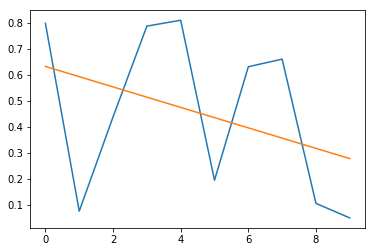

In [9]:
y = np.array([ 0.7972,  0.0767,  0.4383,  0.7866,  0.8091, 0.1954,  0.6307,  0.6599,  0.1065,  0.0508]) 
x = np.arange(len(y))

regression = np.polyfit(x, y, 1)
regression
# y = regression[0] * x + regression[1]

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y)
new_y = [regression[0]*i+regression[1] for i in x]
plt.plot(new_y)

## ZSCORE
Calculates the z score of each value in the sample, relative to the sample mean and standard deviation.

https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.zscore.html

In [5]:
import numpy as np
from scipy import stats

a = np.array([ 0.7972,  0.0767,  0.4383,  0.7866,  0.8091, 0.1954,  0.6307,  0.6599,  0.1065,  0.0508])
stats.zscore(a)

array([ 1.12724554, -1.2469956 , -0.05542642,  1.09231569,  1.16645923,
       -0.8558472 ,  0.57858329,  0.67480514, -1.14879659, -1.33234306])

### for vini

In [117]:
import os
import sys
from collections import defaultdict
os.chdir("/home/foodmap/food101/")
from processing.location.locations import Countries

def getCountriesAsList():
    countriesIndex, countriesInfo = Countries.loadFromFile()
    country_list = list()
    for k,v in countriesInfo.iteritems():
        country_list.append(v[0])
    return country_list

In [119]:
a = getCountriesAsList()
print len(a), a

All countries with all names:  24782
All countries unique geonameid:   251
251 [u'vietnam', u'slovakia', u'barbados', u'sierra leone', u'republic of the congo', u'suriname', u'latvia', u'syria', u'dominica', u'uruguay', u'montenegro', u'british indian ocean territory', u'russia', u'palau', u'mayotte', u'isle of man', u'benin', u'laos', u'new caledonia', u'saint kitts and nevis', u'afghanistan', u'cameroon', u'finland', u'democratic republic of the congo', u'guatemala', u'heard island and mcdonald islands', u'saint martin', u'solomon islands', u'denmark', u'guernsey', u'iceland', u'dominican republic', u'slovenia', u'belarus', u'svalbard and jan mayen', u'gibraltar', u'puerto rico', u'djibouti', u'ethiopia', u'kosovo', u'hong kong', u'zimbabwe', u'curacao', u'tanzania', u'marshall islands', u'east timor', u'eritrea', u'macao', u'bonaire, saint eustatius and saba ', u'bermuda', u'tokelau', u'estonia', u'ukraine', u'taiwan', u'egypt', u'norfolk island', u'saint barthelemy', u'seychelles',